In [20]:
# Download video from youtube, using pytube as API

In [1]:
import sys
from pytube import YouTube
import os

def download_video(url, output_path='videos'):   ## downlod video under /video folder
    """
    funtion to download videos
    """
    try:

        os.makedirs(output_path, exist_ok=True)
        yt = YouTube(url)
        video = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
        
        # download video
        if video:
            video.download(output_path=output_path)
            print(f"Downloaded video to {os.path.join(output_path, video.default_filename)}")
        else:
            print("No mp4 video available for download.")
                
    except Exception as e:
        print(f"An error occurred: {e}")

In [23]:
## Call download_video function to download the video
youtube_url = 'https://www.youtube.com/watch?v=wbWRWeVe1XE'
download_video(youtube_url)

Downloaded video to videos/What Does High-Quality Preschool Look Like  NPR Ed.mp4


In [24]:
youtube_url = 'https://www.youtube.com/watch?v=FlJoBhLnqkoE'
download_video(youtube_url)

Downloaded video to videos/How Green Roofs Can Help Cities  NPR.mp4


In [25]:
youtube_url = 'https://www.youtube.com/watch?v=Y-bVwPRy_no'
download_video(youtube_url)

Downloaded video to videos/Why It’s Usually Hotter In A City  Lets Talk  NPR.mp4


In [18]:
## Video Preprocess

In [2]:
import cv2
from moviepy.editor import VideoFileClip
import numpy as np

def preprocess_video_frames(video_path, skip_frames=10, frame_size=(224, 224), scale=True, normalize=True):
    """
    - Input video
    - Sample video by skipping every 10 frame
    - scale / resize / normalize image for deep leaning model training

    - return a dictionary which contains: 
        - preprocessed video frame
        - framenum and timestamp of very video
        
    """
    processed_frames = []
    timestamps = []

    # Open the video file
    video_clip = VideoFileClip(video_path)

    ## fps for the video to calculate timestamp
    fps = video_clip.fps

    # Iterate over each frame in the video
    for frame_count, frame in enumerate(video_clip.iter_frames(fps=video_clip.fps)):
        if frame_count % skip_frames == 0:
            # Convert BGR to RGB
            frame_rgb = frame[:, :, ::-1]

            # Resize the frame
            resized_frame = cv2.resize(frame_rgb, frame_size)

            if scale:
                resized_frame = resized_frame / 255.0 ## float32

            if normalize:
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                resized_frame = (resized_frame - mean) / std

            timestamp = frame_count / fps
            
            processed_frames.append({'frame': resized_frame, 'frameNum': frame_count, 'timestamp': timestamp})

    return processed_frames


In [19]:
# Detection

In [3]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch
from torchvision.transforms import functional as F
# from preprocess import preprocess_video_frames

## Load fasterrcnn model
def load_pretrained_model():
    # model = fasterrcnn_resnet50_fpn(pretrained=True)
    model = fasterrcnn_resnet50_fpn(pretrained=True).float()
    model.eval()
    return model

## Mapping the label in detection results into coco class name
def label_to_class_name(label):

    COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush']

    cls=COCO_INSTANCE_CATEGORY_NAMES[label]

    return cls

## Obtain the detection results for one frame
def detect_frame(frame):
    model = load_pretrained_model()
    with torch.no_grad():
        detection = model(frame)
    prediction = detection[0]
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    return boxes,labels,scores

## Process model predictions into the format of [vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info]
def process_predictions(predictions, frameNum, timestamp):

    processed_results = []
    prediction = predictions[0]  # Assuming batch size of 1

    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    detectedObjId = 0
    for box, label, score in zip(boxes, labels, scores):
        class_name = label_to_class_name(label)
        result = {
            'frameNum': frameNum,
            'timestamp': timestamp,
            'detectedObjId': detectedObjId,
            'label': class_name,
            'score': score.item(),
            'bbox': box.tolist(),
        }
        processed_results.append(result)
        detectedObjId += 1 

    return processed_results


### API to generate the predictions results for one video in required format
def detect_objects(processed_frames_info, model):
    detections = []
    for frame_info in processed_frames_info:
        # input format float32
        frame = frame_info['frame']
        frame_tensor = torch.tensor(frame, dtype=torch.float32)

        ## asjust the input channel [C, H, W]
        frame_tensor = frame_tensor.permute(2, 0, 1)

        # [C, H, W] --> [N, C, H, W]
        frame_tensor = frame_tensor.unsqueeze(0)
        
        # Perform inference
        with torch.no_grad():
            prediction = model(frame_tensor)

        # Process prediction results
        frame_detections = process_predictions(prediction,frame_info['frameNum'], frame_info['timestamp'])
        detections.extend(frame_detections)

    return detections

In [29]:
## Call the video detection functions to generate the detetction results of 3 given videos while saving the results into a .csv file 
## and print the the detected object classes

import csv
from collections import Counter
# from preprocess import preprocess_video_frames
# from detect_objects import detect_objects,load_pretrained_model

videos = {
    "vid1": "videos/How Green Roofs Can Help Cities  NPR.mp4",
    "vid2": "videos/What Does High-Quality Preschool Look Like  NPR Ed.mp4",
    "vid3": "videos/Why It’s Usually Hotter In A City  Lets Talk  NPR.mp4",
}
output_csv = "csv/detected_objects_2.csv"
headers = ["vidId", "frameNum", "timestamp", "detectedObjId", "label", "score", "bbox"]

detected_classes = Counter()

with open(output_csv, 'w', newline='') as file:

    writer = csv.writer(file)
    writer.writerow(headers)

    model = load_pretrained_model()

    for vidId, video_path in videos.items():
        print(vidId)
        processed_frames_info = preprocess_video_frames(video_path)
        detections = detect_objects(processed_frames_info, model)

        for det in detections:
            writer.writerow([vidId, det['frameNum'], det['timestamp'], det['detectedObjId'], det['label'], det['score'], det['bbox']])
            detected_classes[det['label']] += 1

print(f"Detected {len(detected_classes)} unique classes across all videos.")
print("Classes detected:", list(detected_classes.keys()))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/vscode/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160M/160M [00:04<00:00, 38.6MB/s]


vid1
vid2
vid3
Detected 39 unique classes across all videos.
Classes detected: ['couch', 'bowl', 'sink', 'dining table', 'car', 'cat', 'traffic light', 'person', 'sheep', 'bottle', 'parking meter', 'clock', 'microwave', 'cup', 'sports ball', 'bird', 'tv', 'oven', 'chair', 'toilet', 'truck', 'wine glass', 'bench', 'teddy bear', 'train', 'bed', 'bicycle', 'cell phone', 'hair drier', 'vase', 'apple', 'umbrella', 'tennis racket', 'motorcycle', 'scissors', 'refrigerator', 'fire hydrant', 'remote', 'tie']


In [22]:
# Autoencoder

In [3]:
## Data process for training data 

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
from pycocotools.coco import COCO
from torchvision.datasets import CocoDetection
import random

class CocoObjectsCropDataset(CocoDetection):
    """
    - Process COCO training data
    - Crop the classes of interest objects in COCO images as training image 
    - (Optional) Only load a COCO subset as training data by specifying "subset_size"
    """
    def __init__(self, root, annFile, classes_of_interest, subset_size=None, transform=None):
        super(CocoObjectsCropDataset, self).__init__(root, annFile, transform)
        self.coco = COCO(annFile)
        self.classes_of_interest = classes_of_interest
        self.image_ids = self._get_relevant_image_ids(subset_size)
        self.ann_ids = self._get_all_annotations_ids()
        print(f"Initialized dataset with {len(self.image_ids)} images and {len(self.ann_ids)} annotations")

    def _get_relevant_image_ids(self, subset_size=None):
        ids = []
        for i, class_name in enumerate(self.classes_of_interest):
            catIds = self.coco.getCatIds(catNms=[class_name])
            imgIds = self.coco.getImgIds(catIds=catIds)
            ids.extend(imgIds)
            print(f"Processed class {class_name}: {len(imgIds)} images")
        
        # if subset_size is defined, pick a subset of that size
        if subset_size is not None:
            ids = random.sample(ids, min(subset_size, len(ids)))
        
        return list(set(ids))

    def _get_all_annotations_ids(self):
        ann_ids = []
        for img_id in self.image_ids:
            for class_name in self.classes_of_interest:
                catIds = self.coco.getCatIds(catNms=[class_name])
                annIds = self.coco.getAnnIds(imgIds=img_id, catIds=catIds, iscrowd=None)
                ann_ids.extend(annIds)
        return ann_ids

    def __len__(self):
        return len(self.ann_ids)

    def __getitem__(self, index):
        if index % 10000 == 0:
            print(f"Loading image {index + 1}/{len(self.ann_ids)}")
        ann_id = self.ann_ids[index]
        annotation = self.coco.loadAnns(ann_id)[0]
        img_id = annotation['image_id']
        coco_img = self.coco.loadImgs(img_id)[0]
        image = Image.open(os.path.join(self.root, coco_img['file_name'])).convert('RGB')

        bbox = annotation['bbox']
        image = image.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))  ## Crop according to the annotation

        if self.transform is not None:
            image = self.transform(image)

        return image


NOTE! Installing ujson may make loading annotations faster.


In [4]:
## Define the autoencoder

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from PIL import Image
from pycocotools.coco import COCO
# from dataset import CocoObjectsCropDataset


class ConvAutoencoder(nn.Module):
    """
    - Specify the embedding vector size
    - Return the reconstructed image and the embedding 
    """
    def __init__(self, embedding_size=64):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # [batch, 32, 112, 112]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # [batch, 64, 56, 56]
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # [batch, 128, 28, 28]
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # [batch, 256, 14, 14]
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),  # [batch, 512, 7, 7]
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, embedding_size)  # Fully connected layer to generate embeding
        )

        self.decoder_input = nn.Linear(embedding_size, 512 * 7 * 7)  # Input to decoder

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # [batch, 256, 14, 14]
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # [batch, 128, 28, 28]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # [batch, 64, 56, 56]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [batch, 32, 112, 112]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # [batch, 3, 224, 224]
            nn.Sigmoid()
        )

    def forward(self, x):
        embedding = self.encoder(x)
        x = self.decoder_input(embedding)
        x = x.view(-1, 512, 7, 7)  # reshape the embedding to match the input of conv layer
        x = self.decoder(x)
        return x, embedding  # Reconstructed image and embedding


In [6]:
## Antoencoder trainig API
def train_autoencoder(dataset, epochs=10, batch_size=32, learning_rate=1e-3):
    # gpu

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = ConvAutoencoder().to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        print("epoch: ",epoch)
        model.train()
        train_loss = 0.0
        for data in dataloader:
            inputs = data.to(device)
            optimizer.zero_grad()
            
            # forward
            outputs,_ = model(inputs)   ## embedding is not needed right now
            
            # loss
            loss = criterion(outputs, inputs)
            
            # back
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        train_loss = train_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')
        with open("training_log/training_log64.txt", "a") as f:
            f.write(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}\n')
        # if epoch % 10==0:   ## Save the checkpoint every 10 epochs
        torch.save(model.state_dict(), '/workspaces/artificial_intelligence/checkpoint_64/autoencoder_{}.pth'.format(epoch))   ## Saing checkpoint at every epoch
    
    # Save the model
    torch.save(model.state_dict(), '/workspaces/artificial_intelligence/checkpoint_64/autoencoder.pth')

    print('Training complete')
    

In [4]:
## Construct training dataset and by calling the  corresponding APIs

classes_of_interest=['couch', 'bowl', 'sink', 'dining table', 'car', 'cat', 
                     'traffic light', 'person', 'sheep', 'bottle', 'parking meter', 
                     'clock', 'microwave', 'cup', 'sports ball', 'bird', 'tv', 'oven', 
                     'chair', 'toilet', 'truck', 'wine glass', 'bench', 'teddy bear', 'train', 
                     'bed', 'bicycle', 'cell phone', 'hair drier', 'vase', 'apple', 'umbrella', 
                     'tennis racket', 'motorcycle', 'scissors', 'refrigerator', 'fire hydrant', 'remote', 'tie']

coco_root = '/workspaces/coco/train2017'
annFile = '/workspaces/coco/annotations/instances_train2017.json'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
print("Start loading COCO images")
dataset = CocoObjectsCropDataset(coco_root, annFile, classes_of_interest, subset_size=None, transform=transform)

print("Start Traning")
train_autoencoder(dataset,epochs=30, batch_size=32, learning_rate=1e-3)   ## Interuppted at epoch 15

Start loading COCO images
Loading annotations into memory...
Done (t=10.72s)
Creating index...
index created!
Loading annotations into memory...
Done (t=13.15s)
Creating index...
index created!
Processed class couch: 4423 images
Processed class bowl: 7111 images
Processed class sink: 4678 images
Processed class dining table: 11837 images
Processed class car: 12251 images
Processed class cat: 4114 images
Processed class traffic light: 4139 images
Processed class person: 64115 images
Processed class sheep: 1529 images
Processed class bottle: 8501 images
Processed class parking meter: 705 images
Processed class clock: 4659 images
Processed class microwave: 1547 images
Processed class cup: 9189 images
Processed class sports ball: 4262 images
Processed class bird: 3237 images
Processed class tv: 4561 images
Processed class oven: 2877 images
Processed class chair: 12774 images
Processed class toilet: 3353 images
Processed class truck: 6127 images
Processed class wine glass: 2533 images
Proce

KeyboardInterrupt: 

In [5]:
## Autoencoder embedding genration API

import torch
from torchvision import transforms
from PIL import Image
# from autoencoder import ConvAutoencoder
import cv2
from torchvision.transforms.functional import to_pil_image
import numpy as np

def object_embedding(cropped_img_np):
    """
    Return the embedding for the imput image
    """
    # Initialize the auto encoder
    model = ConvAutoencoder()
    model.load_state_dict(torch.load('checkpoint_64/autoencoder_13.pth', map_location=torch.device('cpu')))
    model.eval()

    # Make sure thw input is a numpy array
    if not isinstance(cropped_img_np, np.ndarray):
        raise ValueError("The cropped image must be a numpy array")

    # numpy --> PIL
    cropped_img = to_pil_image(cropped_img_np)

    # Transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # reszie to match the model input size
        transforms.ToTensor(),          # PIL --> tensor
    ])

    # Apply Transform
    img_tensor = transform(cropped_img).unsqueeze(0)

    # Use gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_tensor = img_tensor.to(device)
    model.to(device)

    # Generate embedding
    with torch.no_grad():
        img_reconstruct,embedding = model(img_tensor) 

    embedding_np = embedding.cpu().numpy().flatten()

    return img_reconstruct,embedding_np

In [8]:
# Extra credit : segment the video

In [9]:
import cv2
import numpy as np
# from preprocess import preprocess_video_frames
from detect_objects import detect_frame
# from embedding import object_embedding


def calculate_histogram_diff(frame1, frame2):
    """
    Calculate the histogram difference to determine where to segment the video 
    """
    hist1 = cv2.calcHist([frame1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([frame2], [0], None, [256], [0, 256])
    diff = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)
    return diff

def segment_video_with_flag_frames(preprocessed_frames, threshold=0.3): 
    """
    - Use histogram differences between frames to segment videos
    - Use the first and the last frame as the representative for each segment
    """
    segments = []
    start_frame_info = preprocessed_frames[0]
    for i, frame_info in enumerate(preprocessed_frames[1:], start=1):
        if i < len(preprocessed_frames) - 1:
            next_frame_info = preprocessed_frames[i + 1]       ## use histogram difference between frames to segment videos
            diff = calculate_histogram_diff(frame_info['frame'], next_frame_info['frame'])
            if diff > threshold:
                end_frame_info = preprocessed_frames[i]
                segments.append((start_frame_info, end_frame_info))
                start_frame_info = next_frame_info
    segments.append((start_frame_info, preprocessed_frames[-1]))  # the last segment
    return segments   ## return the end and start frames of each segment and their framenum


def detect_and_generate_embeddings(flag_frame):
    """
    Generate embeddings for the objects in the keyframe
    """
    # objet detectio in key frame
    detections = detect_frame(flag_frame['frame'])
    embeddings = []
    for detection in detections:
        x, y, w, h = detection['bbox']
        cropped_img = flag_frame['frame'][y:y+h, x:x+w]
        # generate embeddings for each object in key f
        _,embedding = object_embedding(cropped_img)
        embeddings.append(embedding)
    return embeddings   ## array of object embeddings in one frame

def video_seg_embedding(video):
    """
    API to generate embedding for video segments
    """
    preprocessed_frames = preprocess_video_frames(video)
    segments = segment_video_with_flag_frames(preprocessed_frames)   ## video divided into segments
    seg_embeddings=[]
    for segment in segments:
        start_frame_info, end_frame_info = segment

        ## Embedding of the first frame

        start_embeddings = detect_and_generate_embeddings(start_frame_info)
        
        ## Embeeding of the last frame
        end_embeddings = detect_and_generate_embeddings(end_frame_info)
        
    seg_embeddings.append(start_embeddings,end_embeddings)

    return seg_embeddings

In [10]:
# Generate the database

In [6]:
## Database config
db_config = {
    'dbname': 'assignment',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'db', 
    'port': '5432'
}

In [7]:
import psycopg2
import csv
# from embedding import object_embedding 
# from preprocess import preprocess_video_frames
import numpy as np


def insert_into_database(vid_id, frame_num, timestamp, detected_obj_id, label, score, bbox, embedding):
    """
    - Connect to the database
    - Insert data into the database
    """
    conn = psycopg2.connect(**db_config)
    cur = conn.cursor()

    insert_query = '''
    INSERT INTO detected_objects_64 (vid_id, frame_num, timestamp, detected_obj_id, label, score, bbox_info, vector)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
    '''

    try:
        cur.execute(insert_query, (vid_id, frame_num, timestamp, detected_obj_id, label, score, str(bbox), embedding))
        conn.commit()
    except Exception as e:
        print(f"An error occurred: {e}")
        conn.rollback()
    finally:
        cur.close()
        conn.close()

def process_video_and_csv(video_path, vid_id, csv_path):
    """
    - Insert the detections results + correspoding embedding of every dataection into the database
    """
    preprocessed_frames = preprocess_video_frames(video_path)
    frame_dict = {frame['frameNum']: frame for frame in preprocessed_frames}

    with open(csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['vidId'] != vid_id:
                continue

            frame_num = int(row['frameNum'])
            frame_info = frame_dict.get(frame_num)
            if not frame_info:
                print(f"No matching frame found at frameNum {frame_num}")
                continue

            bbox = eval(row['bbox'])
            cropped_img = frame_info['frame'][int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]

            _,embedding = object_embedding(cropped_img)
            embedding =embedding.tolist()
            insert_into_database(row['vidId'], frame_num, float(row['timestamp']), int(row['detectedObjId']), row['label'], float(row['score']), bbox, embedding)
            if frame_num%1000==0:    ##print to check insert status every 1000 row
                print(f"Inserted: vidId={row['vidId']}, frameNum={frame_num}, timestamp={row['timestamp']}, detectedObjId={row['detectedObjId']}, label={row['label']}, score={row['score']}, bbox={bbox}, embedding={embedding[:5]}...")


In [15]:
## Perform insertions by calling the APIs

video_path1 = 'videos/How Green Roofs Can Help Cities  NPR.mp4'
vid_id1 = 'vid1'

video_path2 = 'videos/What Does High-Quality Preschool Look Like  NPR Ed.mp4'
vid_id2 = 'vid2'

video_path3 = 'videos/Why It’s Usually Hotter In A City  Lets Talk  NPR.mp4'
vid_id3 = 'vid3'

csv_path = 'csv/detected_objects_2.csv'
print("Inserting Video 1")
process_video_and_csv(video_path1, vid_id1, csv_path)
print("Inserting Video 2")
process_video_and_csv(video_path2, vid_id2, csv_path)
print("Inserting Video 3")
process_video_and_csv(video_path3, vid_id3, csv_path)

Inserting Video 1
Inserted: vidId=vid1, frameNum=1000, timestamp=41.70833333333333, detectedObjId=0, label=car, score=0.06651286035776138, bbox=[114.89112854003906, 125.55664825439453, 126.95548248291016, 141.83084106445312], embedding=[-0.3041570484638214, 0.7774291038513184, 0.03247223049402237, 0.564510703086853, 0.5385053753852844]...
Inserted: vidId=vid1, frameNum=1000, timestamp=41.70833333333333, detectedObjId=1, label=person, score=0.06434673070907593, bbox=[132.64849853515625, 211.71340942382812, 144.0237579345703, 223.67103576660156], embedding=[0.3921218812465668, 0.5623884797096252, -1.558052897453308, 1.7175618410110474, -0.22174811363220215]...
Inserted: vidId=vid1, frameNum=2000, timestamp=83.41666666666666, detectedObjId=0, label=car, score=0.08147940784692764, bbox=[8.155179023742676, 10.367758750915527, 224.0, 210.7288360595703], embedding=[-0.2803339660167694, -0.6617341041564941, 0.001049034297466278, -0.9749337434768677, -0.2866758704185486]...
Inserted: vidId=vid1

In [27]:
# Indexing the embeddings

In [8]:
# from preprocess import preprocess_video_frames
# from autoencoder import ConvAutoencoder
import psycopg2
# from embedding import object_embedding
from PIL import Image
import torch
import cv2
import numpy as np
import ast

db_config = {
    'dbname': 'assignment',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'db',
    'port': '5432'
}

def search_in_database(embedding, top_k=10, threshold=0):
    """
    Match the top 10 similar embeddings in the database
    """
    db_conn = psycopg2.connect(**db_config)
    cur = db_conn.cursor()
    
    embedding_str = "[" + ",".join(map(str, embedding)) + "]"

    query = """
    SELECT * FROM detected_objects_64 
    WHERE score > %s
    ORDER BY vector <-> %s::vector 
    LIMIT %s;
    """
    
    cur.execute(query, (threshold, embedding_str, top_k))
    results = cur.fetchall()
    
    cur.close()
    db_conn.close()
    
    return results

def draw_bbox(frame_array, bbox_info):
    x, y, width, height = bbox_info
    cv2.rectangle(frame_array, (int(x), int(y)), (int(x + width), int(y + height)), (0, 255, 0), 2)
    return frame_array


def get_frame_by_num(frameNum,video_frames_info):
    for frame_info in video_frames_info:
        if frame_info['frameNum'] == frameNum:
            return frame_info['frame']
    return None


In [9]:
import matplotlib.pyplot as plt
def load_and_preprocess_videos(videos):
    """
    Process the 3 videos
    """
    frame_infos = {}
    for vidId, video_path in videos.items():
        processed_frames_info = preprocess_video_frames(video_path)
        frame_infos[vidId] = processed_frames_info
    return frame_infos

def search_and_process_results(embedding, frame_infos):
    """
    - Search in database for the top 10 match
    - Draw bounding box in images
    """
    processed_images = []
    results = search_in_database(embedding)
    for result in results:
        vidID, frameNum, bbox_info = result[0], result[1], result[-2]
        bbox_info = ast.literal_eval(bbox_info)
        video_info = frame_infos[vidID]
        frame_array = get_frame_by_num(frameNum, video_info)
        if frame_array is not None:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            frame_array = (frame_array * std) + mean
            frame_array *= 255.0
            frame_array = np.clip(frame_array, 0, 255).astype(np.uint8)
            drawn_frame = draw_bbox(frame_array, bbox_info)
            processed_images.append(drawn_frame)
    return processed_images

def display_images(images):
    if images:
        plt.figure(figsize=(20, 10))
        for i, img in enumerate(images[:10]):
            plt.subplot(2, 5, i+1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
        plt.show()

def process_and_display_image(image_path, frame_infos):
    input_image = Image.open(image_path)
    input_image = input_image.resize((224, 224))
    input_image = np.array(input_image)
    
    _, embedding = object_embedding(input_image)
    embedding = embedding.tolist()
    print(embedding)
    
    processed_images = search_and_process_results(embedding, frame_infos)
    display_images(processed_images)

In [12]:
videos = {
    "vid1": "videos/How Green Roofs Can Help Cities  NPR.mp4",
    "vid2": "videos/What Does High-Quality Preschool Look Like  NPR Ed.mp4",
    "vid3": "videos/Why It’s Usually Hotter In A City  Lets Talk  NPR.mp4",
}

frame_infos = load_and_preprocess_videos(videos)

In [13]:
## Results

In [202]:
class ConvAutoencoder(nn.Module):
    """
    - Specify the embedding vector size
    - Return the reconstructed image and the embedding 
    """
    def __init__(self, embedding_size=32):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # [batch, 32, 112, 112]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # [batch, 64, 56, 56]
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # [batch, 128, 28, 28]
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # [batch, 256, 14, 14]
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),  # [batch, 512, 7, 7]
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, embedding_size)  # Fully connected layer to generate embeding
        )

        self.decoder_input = nn.Linear(embedding_size, 512 * 7 * 7)  # Input to decoder

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # [batch, 256, 14, 14]
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # [batch, 128, 28, 28]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # [batch, 64, 56, 56]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [batch, 32, 112, 112]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # [batch, 3, 224, 224]
            nn.Sigmoid()
        )

    def forward(self, x):
        embedding = self.encoder(x)
        x = self.decoder_input(embedding)
        x = x.view(-1, 512, 7, 7)  # reshape the embedding to match the input of conv layer
        x = self.decoder(x)
        return x, embedding  # Reconstructed image and embedding


def object_embedding(cropped_img_np):
    """
    Return the embedding for the imput image
    """
    # Initialize the auto encoder
    model = ConvAutoencoder()
    model.load_state_dict(torch.load('checkpoint/autoencoder.pth', map_location=torch.device('cpu')))
    model.eval()

    # Make sure thw input is a numpy array
    if not isinstance(cropped_img_np, np.ndarray):
        raise ValueError("The cropped image must be a numpy array")

    # numpy --> PIL
    cropped_img = to_pil_image(cropped_img_np)

    # Transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # reszie to match the model input size
        transforms.ToTensor(),          # PIL --> tensor
    ])

    # Apply Transform
    img_tensor = transform(cropped_img).unsqueeze(0)

    # Use gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_tensor = img_tensor.to(device)
    model.to(device)

    # Generate embedding
    with torch.no_grad():
        img_reconstruct,embedding = model(img_tensor) 

    embedding_np = embedding.cpu().numpy().flatten()

    return img_reconstruct,embedding_np


def insert_into_database(vid_id, frame_num, timestamp, detected_obj_id, label, score, bbox, embedding):
    """
    - Connect to the database
    - Insert data into the database
    """
    conn = psycopg2.connect(**db_config)
    cur = conn.cursor()

    insert_query = '''
    INSERT INTO detected_objects (vid_id, frame_num, timestamp, detected_obj_id, label, score, bbox_info, vector)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
    '''

    try:
        cur.execute(insert_query, (vid_id, frame_num, timestamp, detected_obj_id, label, score, str(bbox), embedding))
        conn.commit()
    except Exception as e:
        print(f"An error occurred: {e}")
        conn.rollback()
    finally:
        cur.close()
        conn.close()

def search_in_database(embedding, top_k=10, threshold=0.3):
    """
    Match the top 10 similar embeddings in the database
    """
    db_conn = psycopg2.connect(**db_config)
    cur = db_conn.cursor()
    
    embedding_str = "[" + ",".join(map(str, embedding)) + "]"

    query = """
    SELECT * FROM detected_objects 
    WHERE score > %s
    ORDER BY vector <-> %s::vector 
    LIMIT %s;
    """
    
    cur.execute(query, (threshold, embedding_str, top_k))
    results = cur.fetchall()
    
    cur.close()
    db_conn.close()
    
    return results



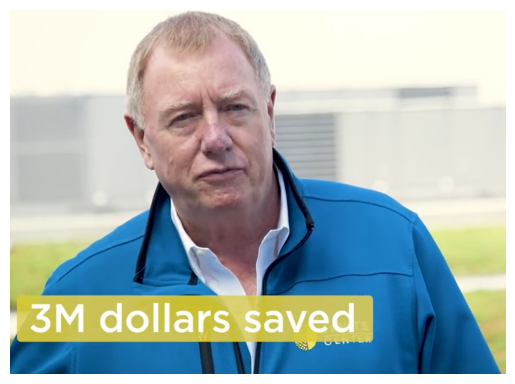

In [18]:
## People from video 1

image_path='query_img/vid_1_people.png'
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()

[-1.5970286130905151, 0.6381904482841492, 3.5703816413879395, 0.5087084770202637, 1.0447486639022827, -1.9424054622650146, 3.4811618328094482, 3.3990938663482666, 2.9175937175750732, 1.1988874673843384, -1.4016716480255127, 1.8580106496810913, -0.4300408661365509, 0.7618874311447144, -0.0019530467689037323, -0.30180132389068604, -0.2714426815509796, -1.8317736387252808, 0.6925683617591858, -1.0596795082092285, 0.4887343645095825, 1.2743029594421387, 0.5508731007575989, 0.13985233008861542, -0.8972849249839783, -0.6020936965942383, 0.5888890624046326, 2.1634252071380615, 0.4436042308807373, -0.20941026508808136, 1.5835282802581787, -0.8566617369651794]


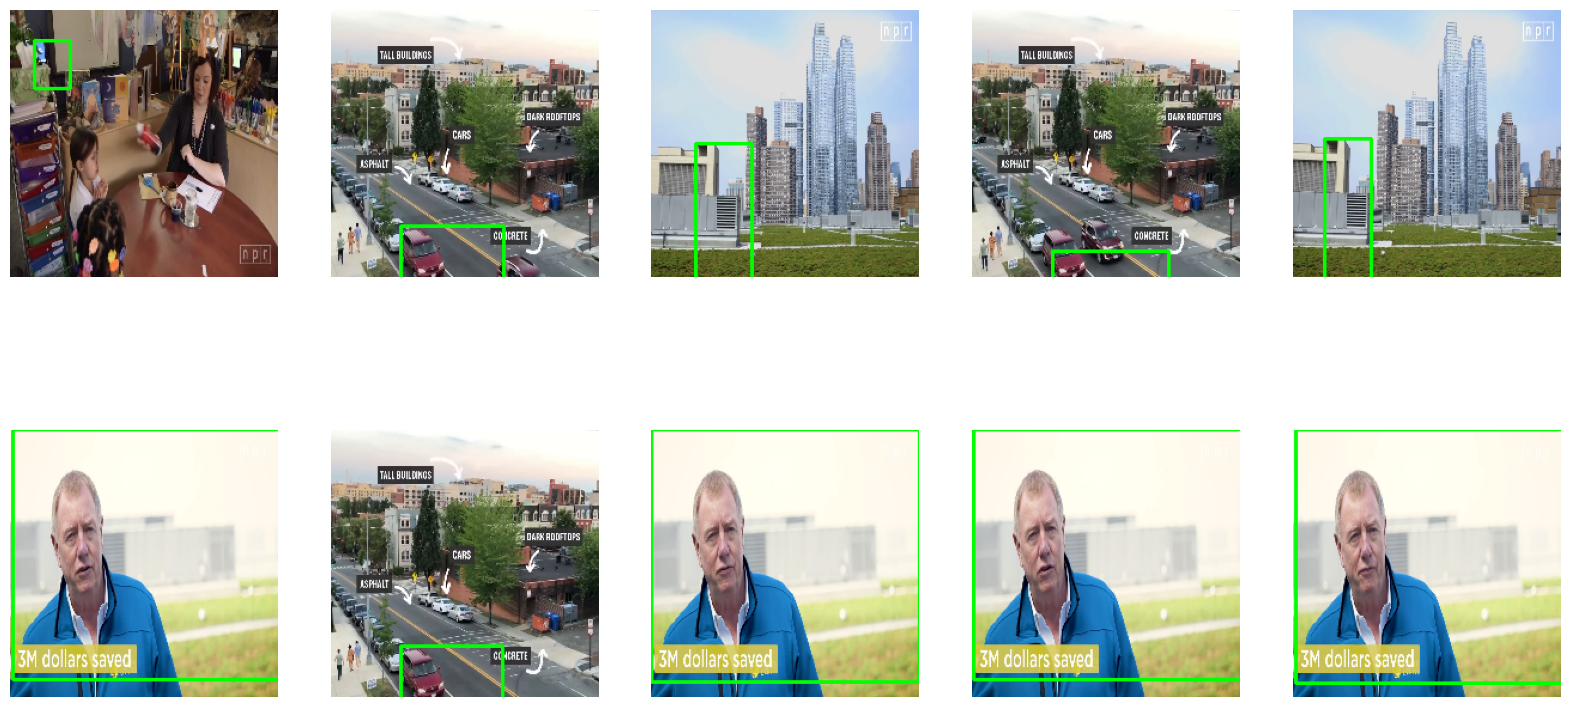

In [19]:
process_and_display_image(image_path, frame_infos)

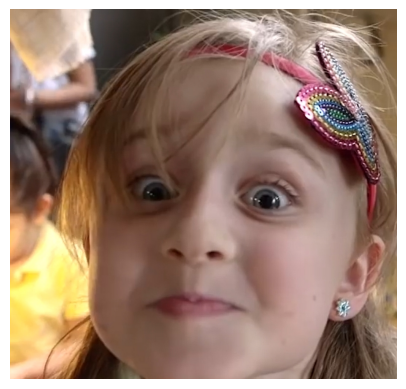

In [203]:
## People from video 2
image_path='query_img/vid_2_people_1.png'
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()

[-0.024440936744213104, 0.6974480748176575, 0.46038565039634705, -0.07941041886806488, -0.5699028372764587, 0.17698535323143005, 1.157427430152893, 0.3265642523765564, 0.3646908402442932, 1.025557279586792, -1.0357946157455444, -0.9445209503173828, -0.611769437789917, -0.5346338748931885, -1.245068073272705, 1.796398639678955, 0.6926313042640686, -2.688095808029175, -1.216310977935791, 2.1510915756225586, 0.18487682938575745, -1.6320843696594238, -0.06119243800640106, -0.0841805562376976, -0.40546661615371704, -1.3937796354293823, 0.37259939312934875, 0.07963890582323074, -0.8706432580947876, 0.18459239602088928, -0.4773107171058655, -0.353593111038208]


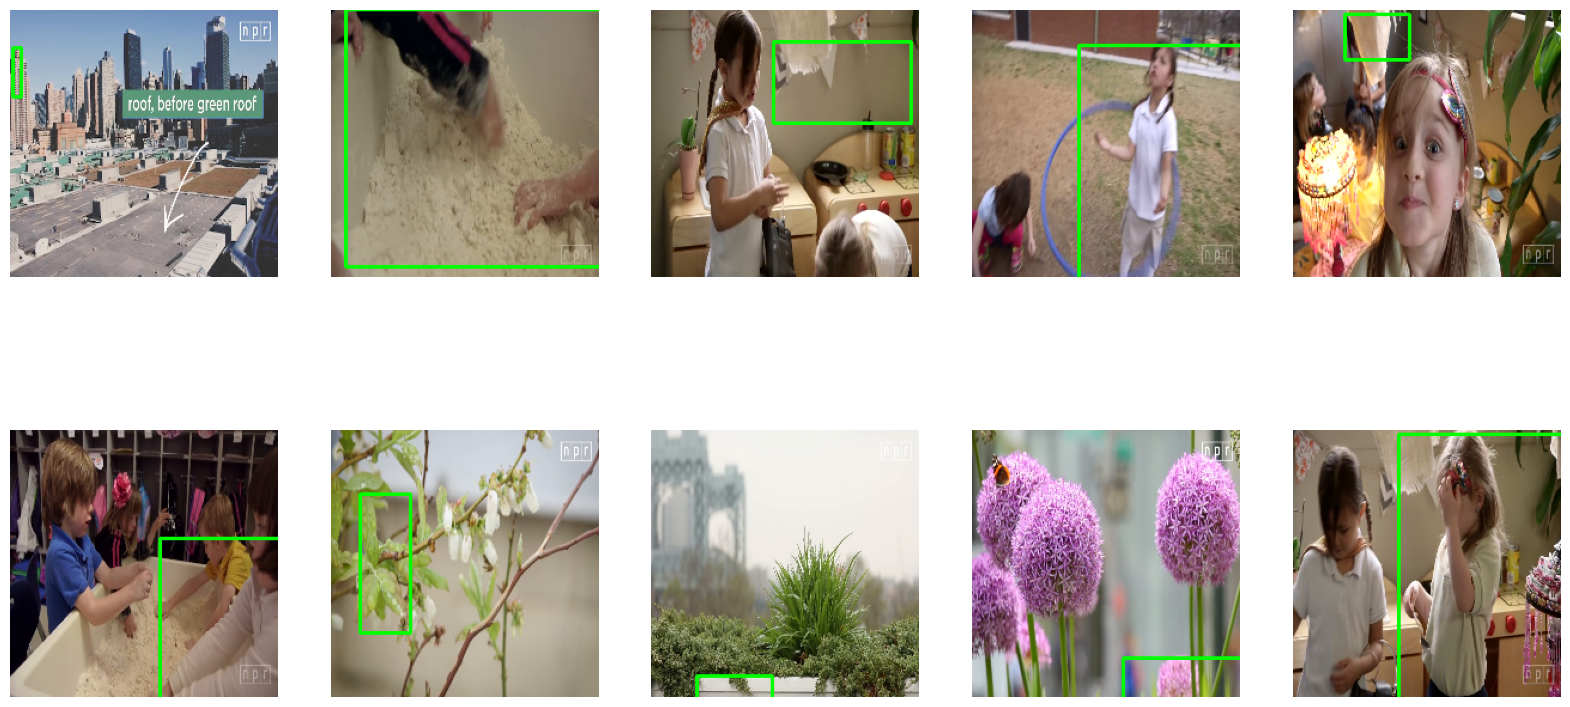

In [204]:
process_and_display_image(image_path, frame_infos)

In [78]:
### Embedding size 32, Trained on the whole coco subset for 30 epochs

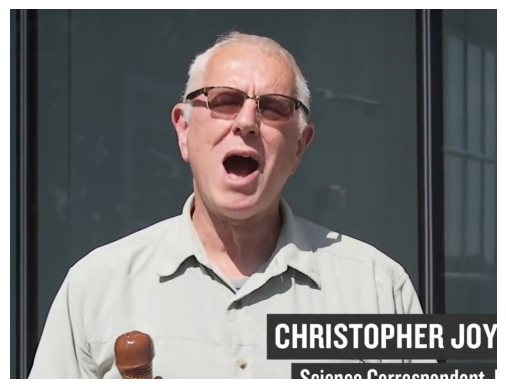

In [22]:
## People from video 3

image_path='query_img/vid_3_people.png'
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()

[3.2275569438934326, -1.5683192014694214, -1.278594970703125, -1.5082498788833618, 0.3737274408340454, 1.0464164018630981, 0.5252833366394043, -0.17332662642002106, -0.825032651424408, -0.2385154813528061, 1.446370244026184, 0.7229645252227783, 1.5842840671539307, -0.22176431119441986, -1.1059014797210693, -0.6594470739364624, 2.0858733654022217, -0.3162539005279541, -0.08843168616294861, -1.0665652751922607, -0.12357126176357269, -0.7389704585075378, -0.5170329809188843, -0.34092259407043457, 1.8571478128433228, 0.19629311561584473, -2.218390464782715, -0.29328858852386475, 0.30089300870895386, 0.4050382971763611, -0.6493300199508667, -0.2813042402267456]


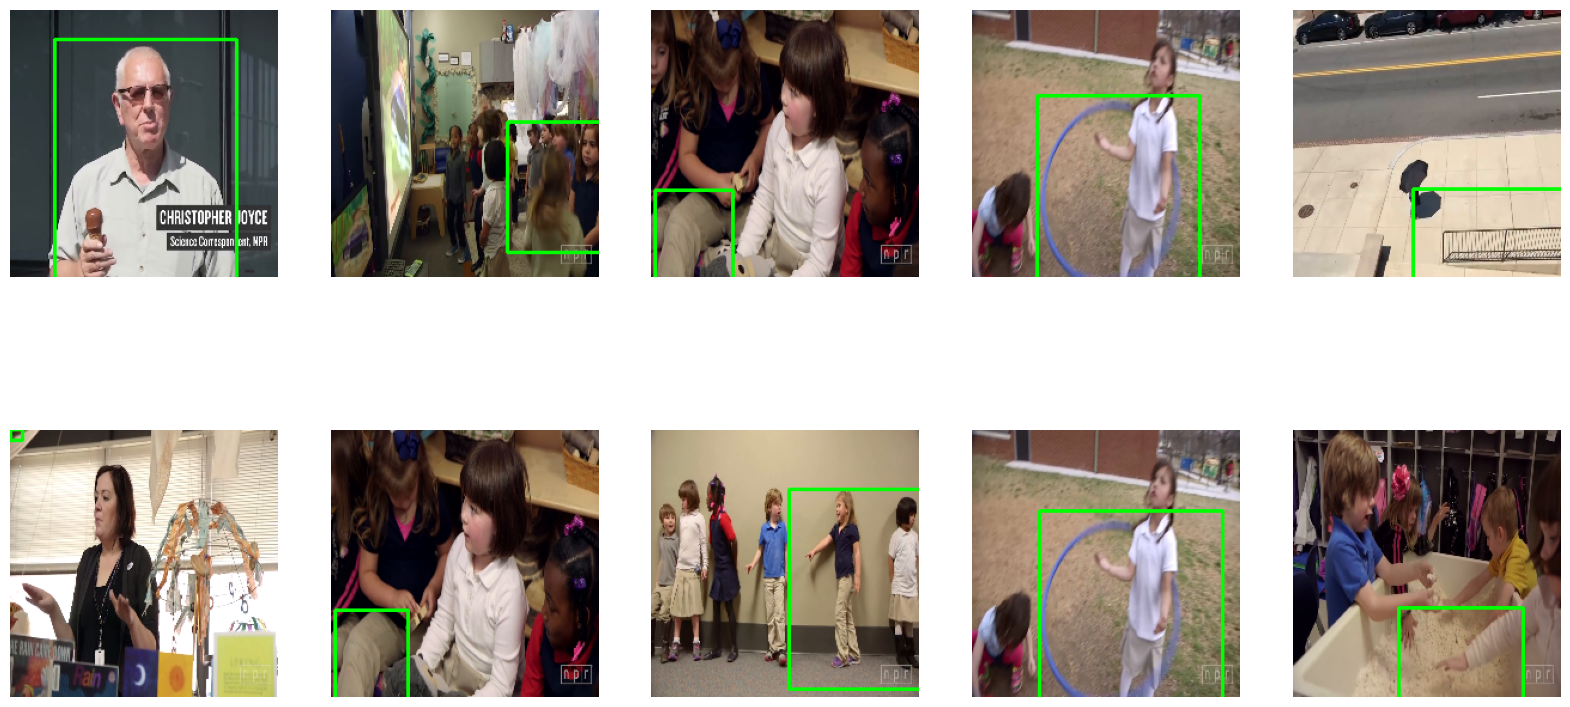

In [23]:
process_and_display_image(image_path, frame_infos)

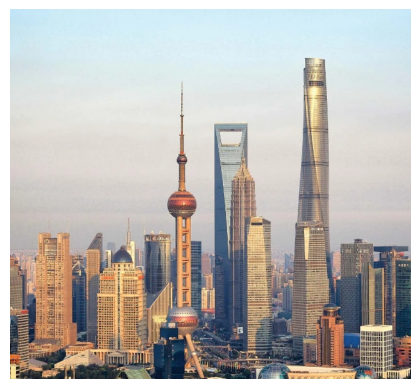

In [34]:
## People from the Internet

image_path='query_img/buillding.png'
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()

[-0.9992342591285706, 0.584006667137146, 0.6010196805000305, 1.6887401342391968, -0.30157503485679626, -1.3074657917022705, 3.6597678661346436, 1.8122828006744385, -0.13356752693653107, -0.2266710251569748, 0.39596372842788696, 0.9827399253845215, 0.024568632245063782, 0.09139388799667358, 0.34868142008781433, 0.028902266174554825, 1.2540065050125122, 0.3756341338157654, 0.8381468653678894, -1.3142684698104858, -0.07103139162063599, 1.2756012678146362, 1.1127537488937378, 0.37972158193588257, -1.1195459365844727, -1.2623751163482666, -0.43043333292007446, 0.19565322995185852, -0.12020286172628403, 0.385413259267807, 2.7684409618377686, -0.45656153559684753]


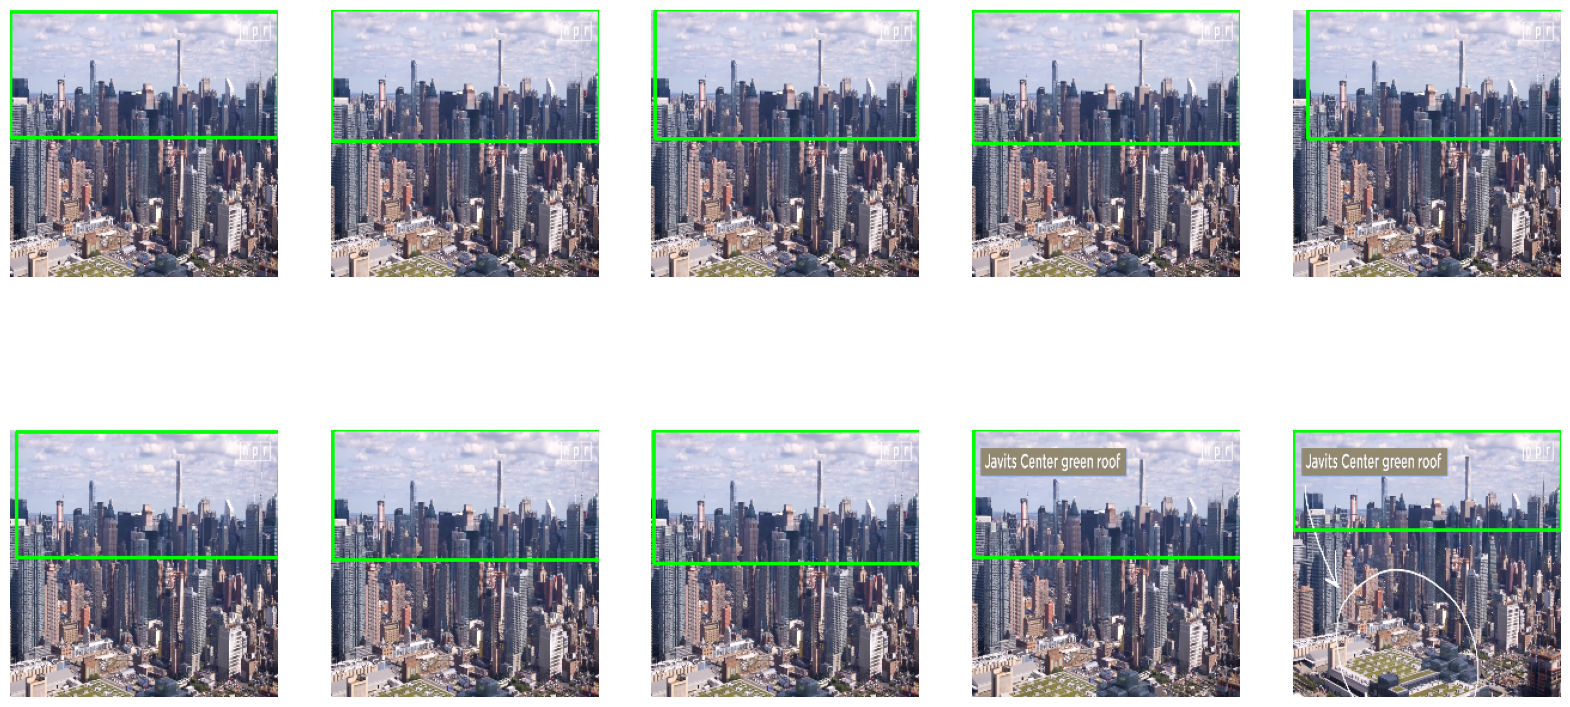

In [35]:
process_and_display_image(image_path, frame_infos)

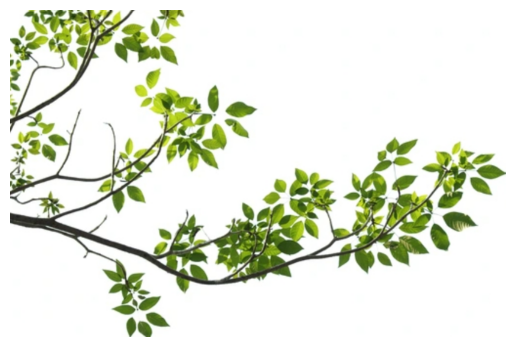

In [205]:
## People from the Internet

image_path='query_img/grass.png'
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()

[0.2551102340221405, 0.43655475974082947, -0.7911584973335266, -0.1472325623035431, -0.7152068614959717, 0.6935244798660278, 6.855790615081787, 4.874061107635498, -0.7006699442863464, 3.025535821914673, -1.8909146785736084, 0.1713900864124298, -0.41106978058815, -0.9891576766967773, 0.6411800980567932, 1.9640696048736572, -1.0549378395080566, 0.30820995569229126, 1.5323586463928223, 0.8815522193908691, -2.0360169410705566, 0.38983261585235596, 0.036879174411296844, 0.2732667922973633, -3.205004930496216, 0.5999947190284729, -0.16243977844715118, -0.044320881366729736, 2.927875280380249, -0.07307429611682892, 0.3173542320728302, 0.725272536277771]


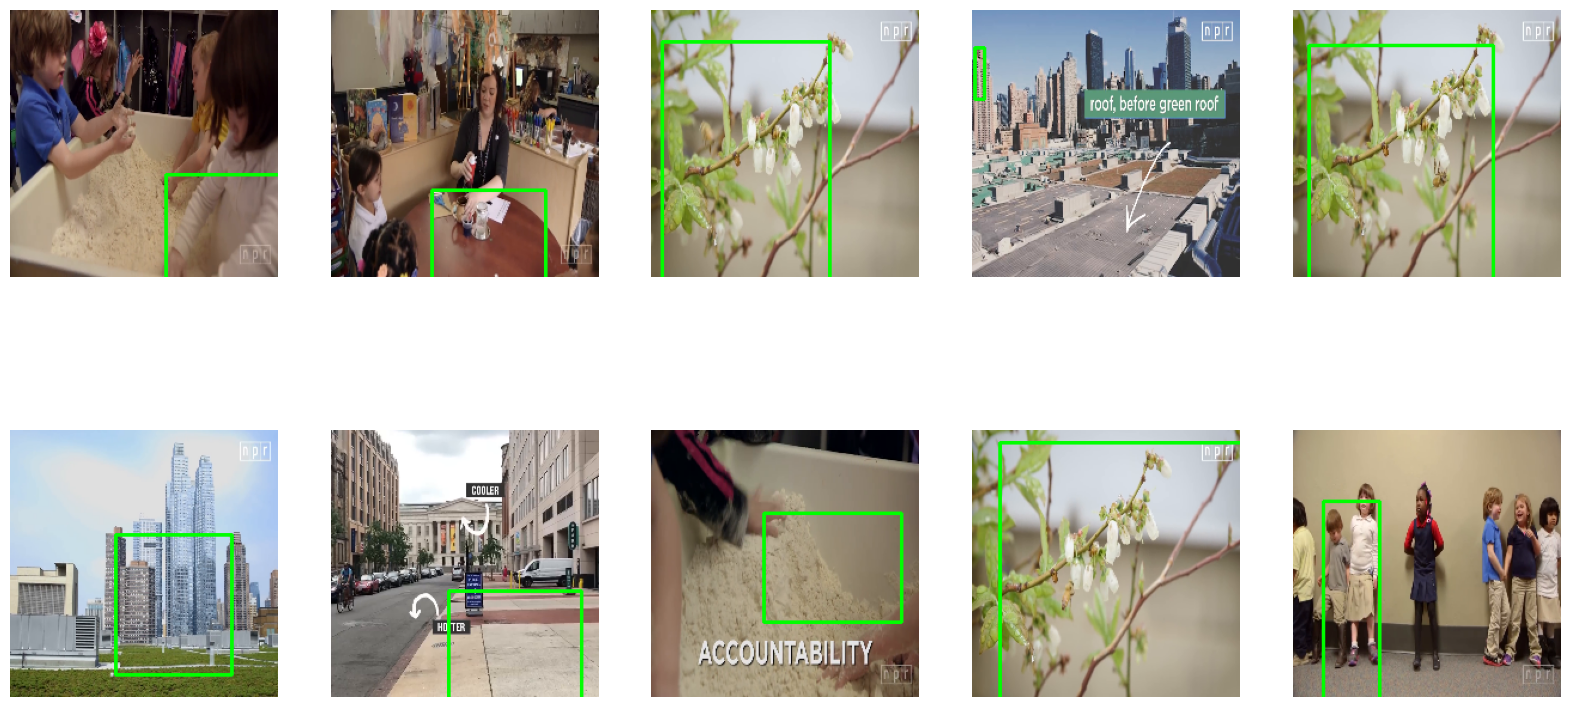

In [206]:
process_and_display_image(image_path, frame_infos)